In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

sns.set_style('whitegrid')

In [2]:
# Dataset: Kaggle Store Sales Time Series Forecasting
# Download train.csv and test.csv from:
# https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data
# Place both files in the same folder as this notebook before running

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()

Mounted at /content/drive
Train shape: (3000888, 6)
Test shape: (28512, 5)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# ***Data Cleaning***


In [3]:
#Check for missing values
missing_val=train.isnull().sum()
print(missing_val)
#Check for duplicates
duplicate_val= train.duplicated().sum()
print("Duplicate rows:",duplicate_val)
#Basic statistics for sales
print(train['sales'].describe())
#Remove negative or zero sales
train = train[train['sales'] >= 0]
#Sort by date
train=train.sort_values('date').reset_index(drop=True)






id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
Duplicate rows: 0
count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64


In [8]:
train['day_of_week']=train['date'].dt.day_name()
train['is_weekend'] = train['date'].dt.weekday >= 5
train['month'] = train['date'].dt.month
train['week_of_year'] = train['date'].dt.isocalendar().week
train['day_of_week_num'] = train['date'].dt.weekday

train.tail()

,id,date,store_nbr,family,sales,onpromotion,day_of_week,is_weekend,month,week_of_year,day_of_week_num,sales_lag_1,sales_lag_7,rolling_7
2988409,2993627,2017-08-11,54,SEAFOOD,0.0,0,Friday,False,8,32,4,2.0,0.0,3.000000
2988410,2995409,2017-08-12,54,SEAFOOD,1.0,1,Saturday,True,8,32,5,0.0,3.0,3.000000
2988411,2997191,2017-08-13,54,SEAFOOD,2.0,0,Sunday,True,8,32,6,1.0,0.0,2.714286
2988412,2998973,2017-08-14,54,SEAFOOD,0.0,0,Monday,False,8,33,0,2.0,0.0,3.000000
2988413,3000755,2017-08-15,54,SEAFOOD,3.0,0,Tuesday,False,8,33,1,0.0,12.0,3.000000


In [5]:
train = train.sort_values(['store_nbr', 'family', 'date'])


train['sales_lag_1'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)

train.head(10)

,id,date,store_nbr,family,sales,onpromotion,day_of_week,is_weekend,month,week_of_year,day_of_week_num,sales_lag_1,sales_lag_7
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Tuesday,False,1,1,1,NaN,NaN
3118,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Wednesday,False,1,1,2,0.0,NaN
4757,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Thursday,False,1,1,3,2.0,NaN
6683,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Friday,False,1,1,4,3.0,NaN
8321,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Saturday,True,1,1,5,3.0,NaN
10103,8910,2013-01-06,1,AUTOMOTIVE,2.0,0,Sunday,True,1,1,6,5.0,NaN
12028,10692,2013-01-07,1,AUTOMOTIVE,0.0,0,Monday,False,1,2,0,2.0,NaN
13667,12474,2013-01-08,1,AUTOMOTIVE,2.0,0,Tuesday,False,1,2,1,0.0,0.0
15449,14256,2013-01-09,1,AUTOMOTIVE,2.0,0,Wednesday,False,1,2,2,2.0,2.0
17231,16038,2013-01-10,1,AUTOMOTIVE,2.0,0,Thursday,False,1,2,3,2.0,3.0


In [6]:
# 7-day rolling average
train['rolling_7'] = (
    train.groupby(['store_nbr', 'family'])['sales']
    .shift(1)
    .rolling(window=7)
    .mean()
)

train.head(15)

,id,date,store_nbr,family,sales,onpromotion,day_of_week,is_weekend,month,week_of_year,day_of_week_num,sales_lag_1,sales_lag_7,rolling_7
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Tuesday,False,1,1,1,NaN,NaN,NaN
3118,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Wednesday,False,1,1,2,0.0,NaN,NaN
4757,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Thursday,False,1,1,3,2.0,NaN,NaN
6683,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Friday,False,1,1,4,3.0,NaN,NaN
8321,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Saturday,True,1,1,5,3.0,NaN,NaN
10103,8910,2013-01-06,1,AUTOMOTIVE,2.0,0,Sunday,True,1,1,6,5.0,NaN,NaN
12028,10692,2013-01-07,1,AUTOMOTIVE,0.0,0,Monday,False,1,2,0,2.0,NaN,NaN
13667,12474,2013-01-08,1,AUTOMOTIVE,2.0,0,Tuesday,False,1,2,1,0.0,0.0,2.142857
15449,14256,2013-01-09,1,AUTOMOTIVE,2.0,0,Wednesday,False,1,2,2,2.0,2.0,2.428571
17231,16038,2013-01-10,1,AUTOMOTIVE,2.0,0,Thursday,False,1,2,3,2.0,3.0,2.428571


In [7]:
train = train.dropna().reset_index(drop=True)

***Data Splitting***

In [12]:
from sklearn.model_selection import train_test_split
split_date='2015-12-01'
train_set=train[train['date'] < split_date]
test_set = train[train['date'] >= split_date]
features = ['day_of_week_num','is_weekend','month','week_of_year','sales_lag_1','sales_lag_7','rolling_7','onpromotion']
target = 'sales'
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1880010, 8)
Test shape: (1108404, 8)


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print("RMSE:", rmse)

RMSE: 389.01803968535114


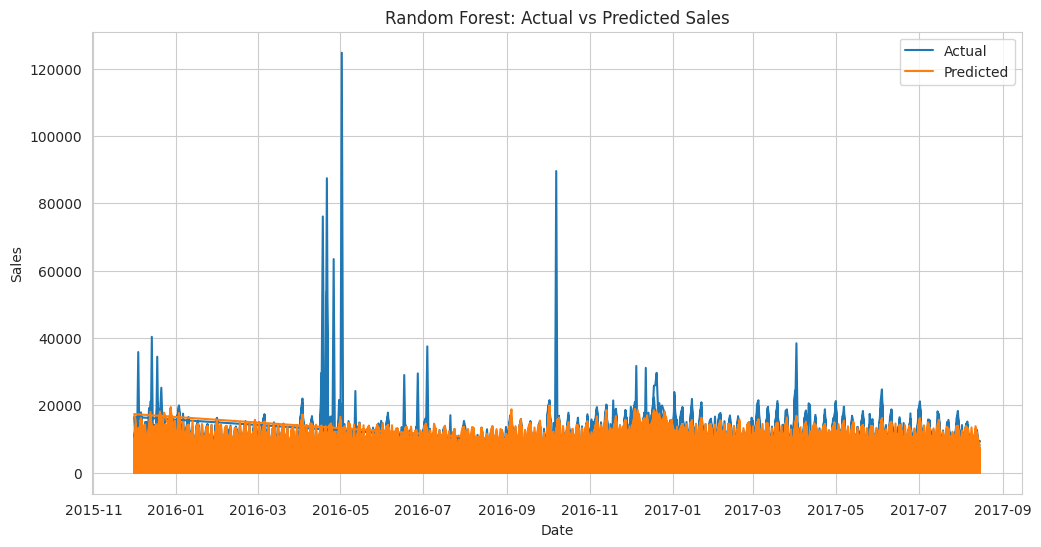

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_set['date'], y_test, label='Actual')
plt.plot(test_set['date'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Random Forest: Actual vs Predicted Sales')
plt.legend()
plt.show()